# Question 3.a

In [2]:
# load predictions from txt file
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_predictions(file_path):
    if not os.path.exists(file_path):
        print("File not found: ", file_path)
        sys.exit(1)
    with open(file_path, 'r') as f:
        lines = f.readlines()
    predictions = [int(x.strip()) for x in lines]
    return predictions

In [134]:
from dont_patronize_me import DontPatronizeMe

def load_datasets():
    dpm = DontPatronizeMe('.', '.')
    dpm.load_task1()
    trids = pd.read_csv('train_semeval_parids-labels.csv')
    teids = pd.read_csv('dev_semeval_parids-labels.csv')

    trids.par_id = trids.par_id.astype(str)
    teids.par_id = teids.par_id.astype(str)

    data=dpm.train_task1_df

    rows = [] # will contain par_id, label and text
    for idx in range(len(trids)):
        parid = trids.par_id[idx]
        keyword = data.loc[data.par_id == parid].keyword.values[0]
        text = data.loc[data.par_id == parid].text.values[0]
        orig_label = int(data.loc[data.par_id == parid].orig_label.values[0])
        label = data.loc[data.par_id == parid].label.values[0]
        rows.append({
            'par_id':parid,
            'community':keyword,
            'text':text,
            'label':label,
            'orig_label':orig_label
        })

    trdf1 = pd.DataFrame(rows)

    rows = [] # will contain par_id, label and text
    for idx in range(len(teids)):
        parid = teids.par_id[idx]
        #print(parid)
        # select row from original dataset
        keyword = data.loc[data.par_id == parid].keyword.values[0]
        text = data.loc[data.par_id == parid].text.values[0]
        orig_label = int(data.loc[data.par_id == parid].orig_label.values[0])
        label = data.loc[data.par_id == parid].label.values[0]
        rows.append({
            'par_id':parid,
            'community':keyword,
            'text':text,
            'label':label,
            'orig_label':orig_label
        })

    tedf1 = pd.DataFrame(rows)

    return trdf1, tedf1

In [182]:
predictions=load_predictions('dev.txt')

In [135]:
train_set, dev_set = load_datasets()

In [183]:
dev_set['pred'] = predictions

In [7]:
dev_set

,par_id,community,text,label,orig_label,pred
0,4046,hopeless,We also know that they can benefit by receivin...,1,3,0
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2,0
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3,0
...,...,...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0,0,0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0,0,0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0,0,0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0,1,0


In [122]:
# Calculate performance metrics for each level of original label
from sklearn.metrics import recall_score

results = []
for label in (2,3,4):
    subset = dev_set[dev_set['orig_label'] == label]
    recall = recall_score(subset['label'], subset['pred'], zero_division=0)
    results.append({'Original Label': label, 'Recall': recall})


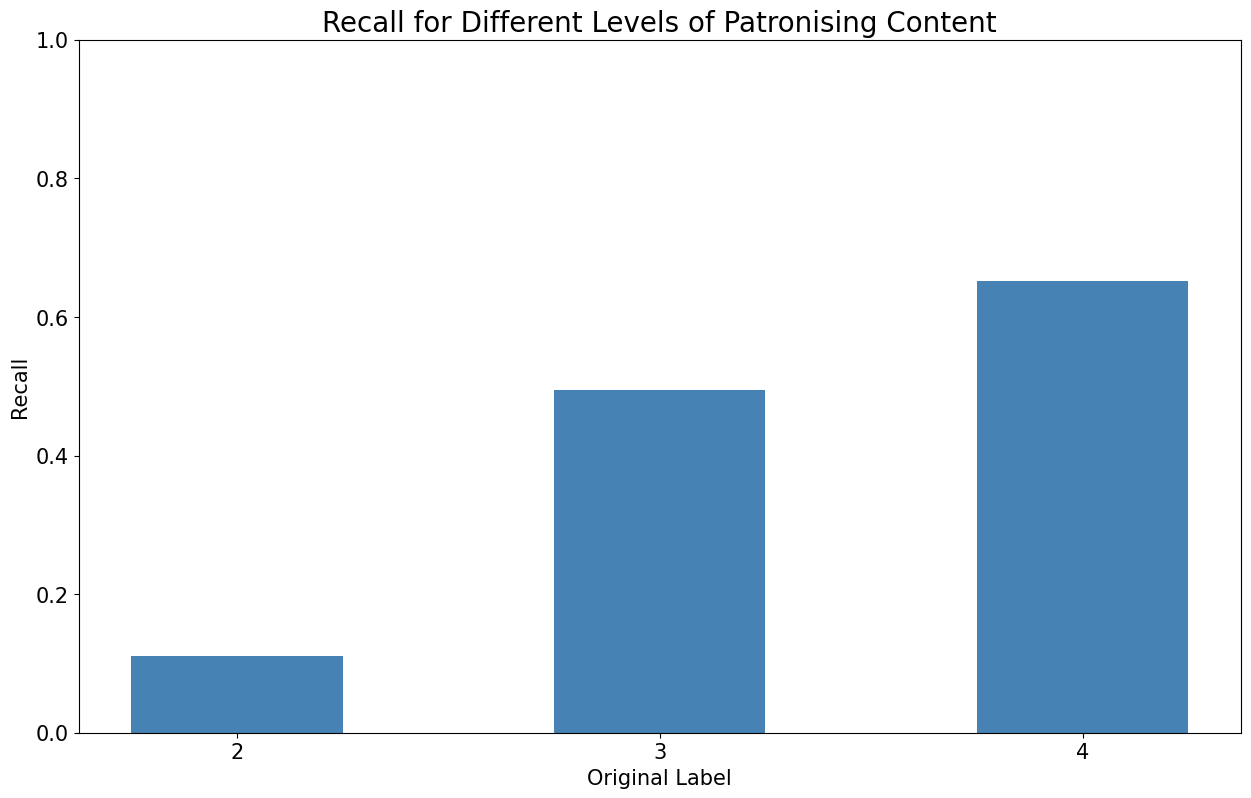

In [123]:
# Prepare data for plotting
labels = [r['Original Label'] for r in results]
recall = [r['Recall'] for r in results]

# Create bar chart
plt.figure(figsize=(15, 9))
plt.bar(labels, recall, color='#4682B4', width=0.5)
plt.xlabel('Original Label', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.title('Recall for Different Levels of Patronising Content', fontsize=20)
plt.xticks(labels, fontsize=15)
plt.ylim(0, 1)
plt.yticks(fontsize=15)
plt.savefig('analysis3a.png')
plt.show()

# Question 3.b

In [ ]:
# Calculate performance metrics for different ranges of text length
from sklearn.metrics import f1_score
results = []

# Define the ranges
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]

# Add text length to the dataframe
dev_set['text_length'] = dev_set['text'].str.len()

for r in ranges:
    subset = dev_set[(dev_set['text_length'] >= r[0]) & (dev_set['text_length'] < r[1])]
    f1 = f1_score(subset['label'], subset['pred'], zero_division=0)
    results.append({'Range': f'{r[0]}-{r[1]}', 'F1': f1})

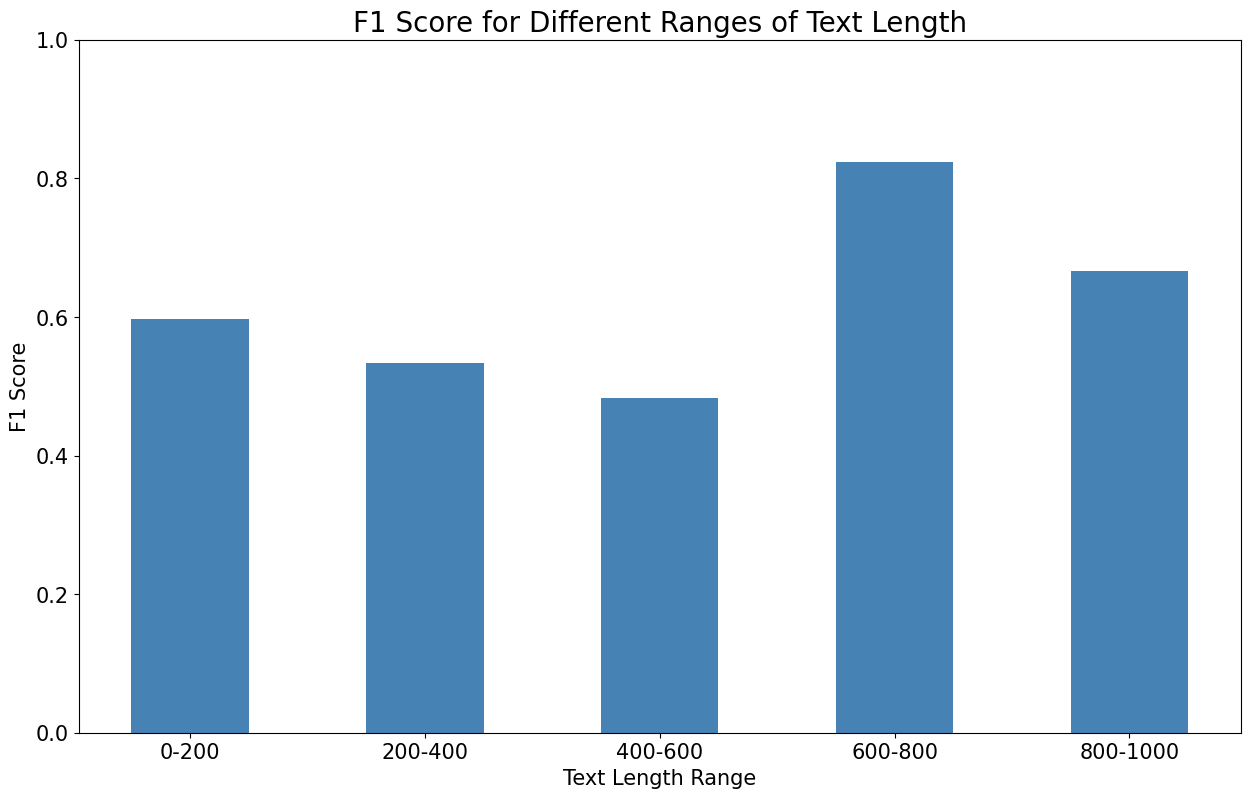

In [ ]:
# Prepare data for plotting
ranges = [r['Range'] for r in results]
f1 = [r['F1'] for r in results]

# Create bar chart
plt.figure(figsize=(15, 9))
plt.bar(ranges, f1, color='#4682B4', width=0.5)
plt.xlabel('Text Length Range', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('F1 Score for Different Ranges of Text Length', fontsize=20)
plt.xticks(ranges, fontsize=15)
plt.ylim(0, 1)
plt.yticks(fontsize=15)
plt.savefig('analysis3b.png')
plt.show()

In [ ]:
# Calculate performance metrics for different ranges of token length
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

results = []

# Define the ranges
ranges = [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150)]

# Add token length to the dataframe
train_set['tokens'] = train_set['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)))

for r in ranges:
    subset = train_set[(train_set['token_length'] >= r[0]) & (train_set['token_length'] < r[1])]
    results.append({'Range': f'{r[0]}-{r[1]}', 'count': len(subset)})

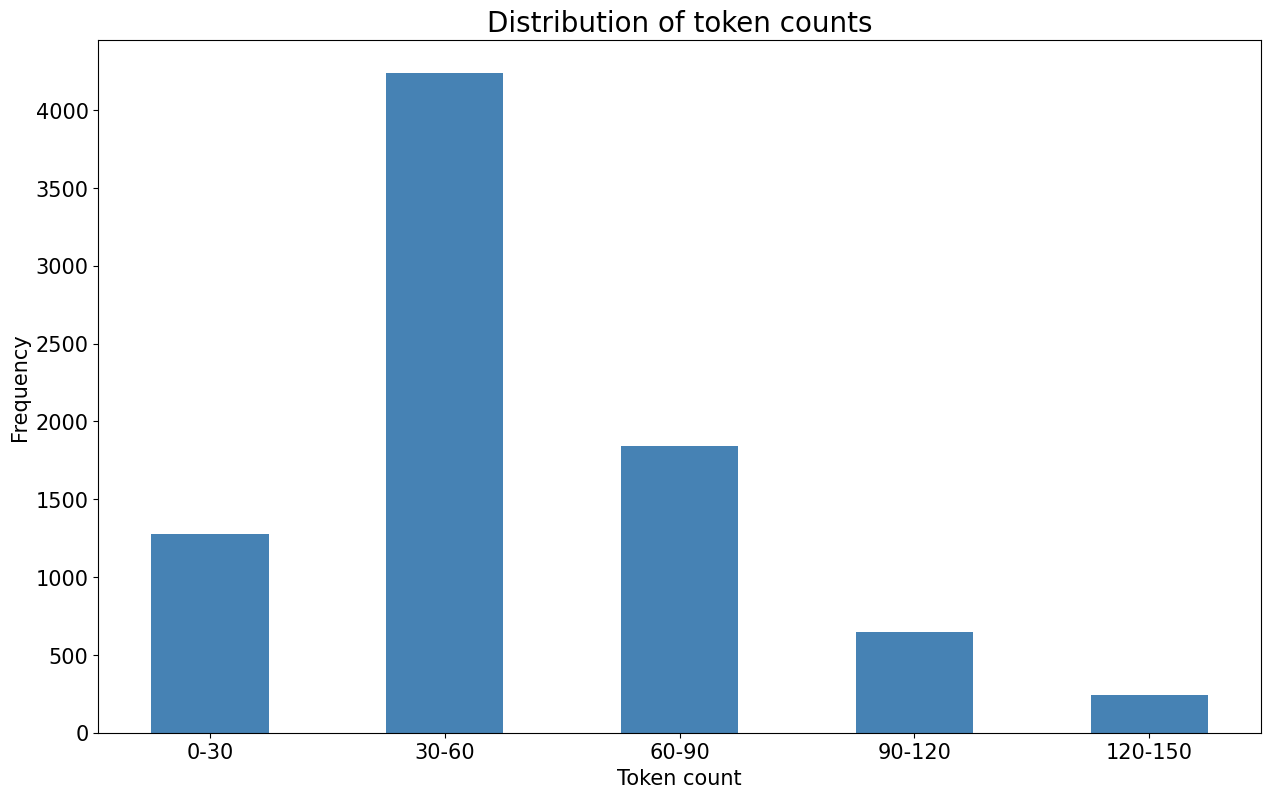

In [ ]:
# Prepare data for plotting
ranges = [r['Range'] for r in results]
count = [r['count'] for r in results]

# Create bar chart
plt.figure(figsize=(15, 9))
plt.bar(ranges, count, color='#4682B4', width=0.5)
plt.xlabel('Token count', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of token counts', fontsize=20)
plt.xticks(ranges, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('analysis3b_token_counts.png')
plt.show()

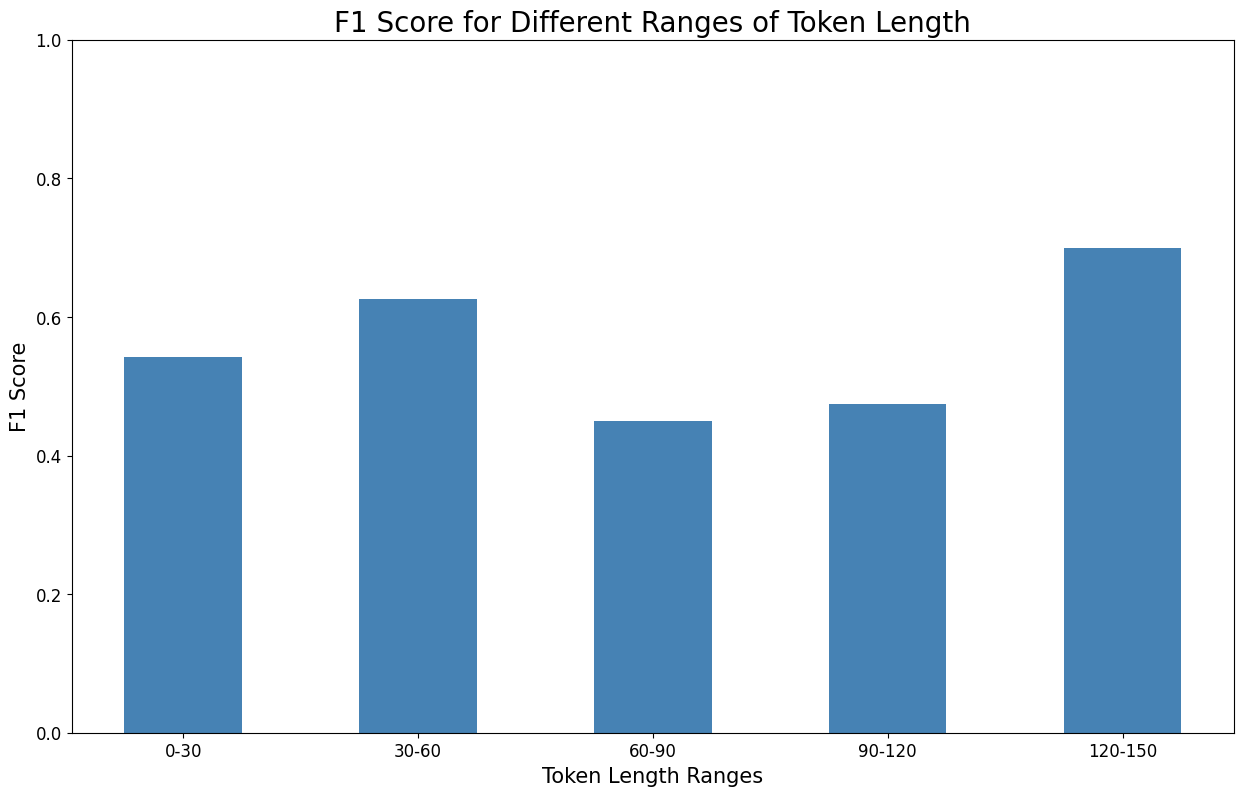

In [ ]:
# Plot distribution of token length of text entries
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import matplotlib.pyplot as plt

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Add token length to the dataframe
dev_set['token_length'] = dev_set['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)))

results = []

# Define the ranges
ranges = [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150)]

for r in ranges:
    # Filter rows where 'token_length' falls within the current range
    subset = dev_set[(dev_set['token_length'] >= r[0]) & (dev_set['token_length'] < r[1])]
    f1 = f1_score(subset['label'], subset['pred'], zero_division=0)
    results.append({'Range': f'{r[0]}-{r[1]}', 'F1': f1})

# Convert results into a DataFrame for plotting
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(15, 9))
plt.bar(results_df['Range'], results_df['F1'], color='#4682B4', width=0.5)
plt.title('F1 Score for Different Ranges of Token Length', fontsize=20)
plt.xlabel('Token Length Ranges', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.ylim(0, 1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('analysis3b_tokens.png')
plt.show()


# Question 3.c

In [111]:
# Calculate performance metrics for each community
from sklearn.metrics import f1_score

results = []
for community in dev_set['community'].unique():
    subset = dev_set[dev_set['community'] == community]
    f1 = f1_score(subset['label'], subset['pred'], zero_division=0)
    results.append({'Community': community, 'F1': f1})

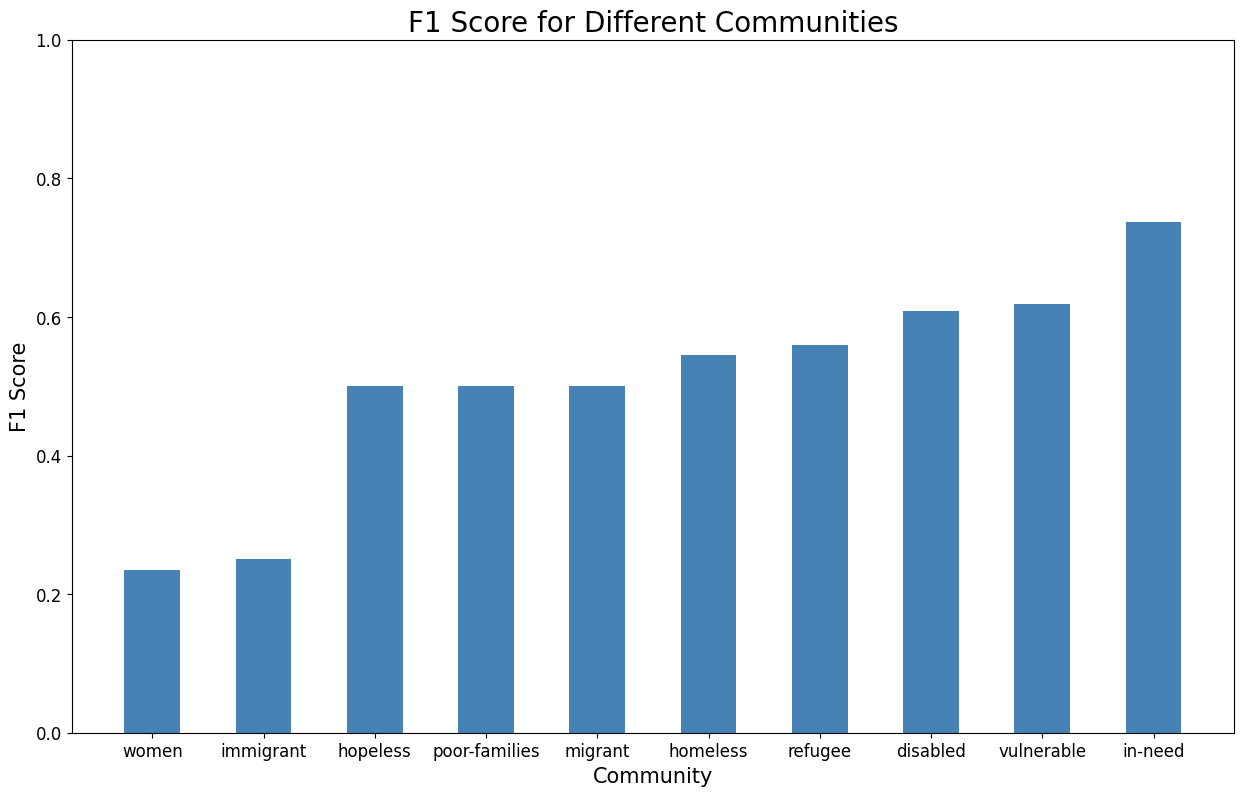

In [116]:
# Prepare data for plotting
communities = [r['Community'] for r in results]
f1 = [r['F1'] for r in results]

# Sort in ascending order of f1 score
communities, f1 = zip(*sorted(zip(communities, f1), key=lambda x: x[1]))

# Create bar chart
plt.figure(figsize=(15, 9))
plt.bar(communities, f1, color='#4682B4', width=0.5)
plt.xlabel('Community', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.title('F1 Score for Different Communities', fontsize=20)
plt.xticks(communities, fontsize=12)
plt.ylim(0, 1)
plt.yticks(fontsize=12)
plt.savefig('analysis3c.png')
plt.show()

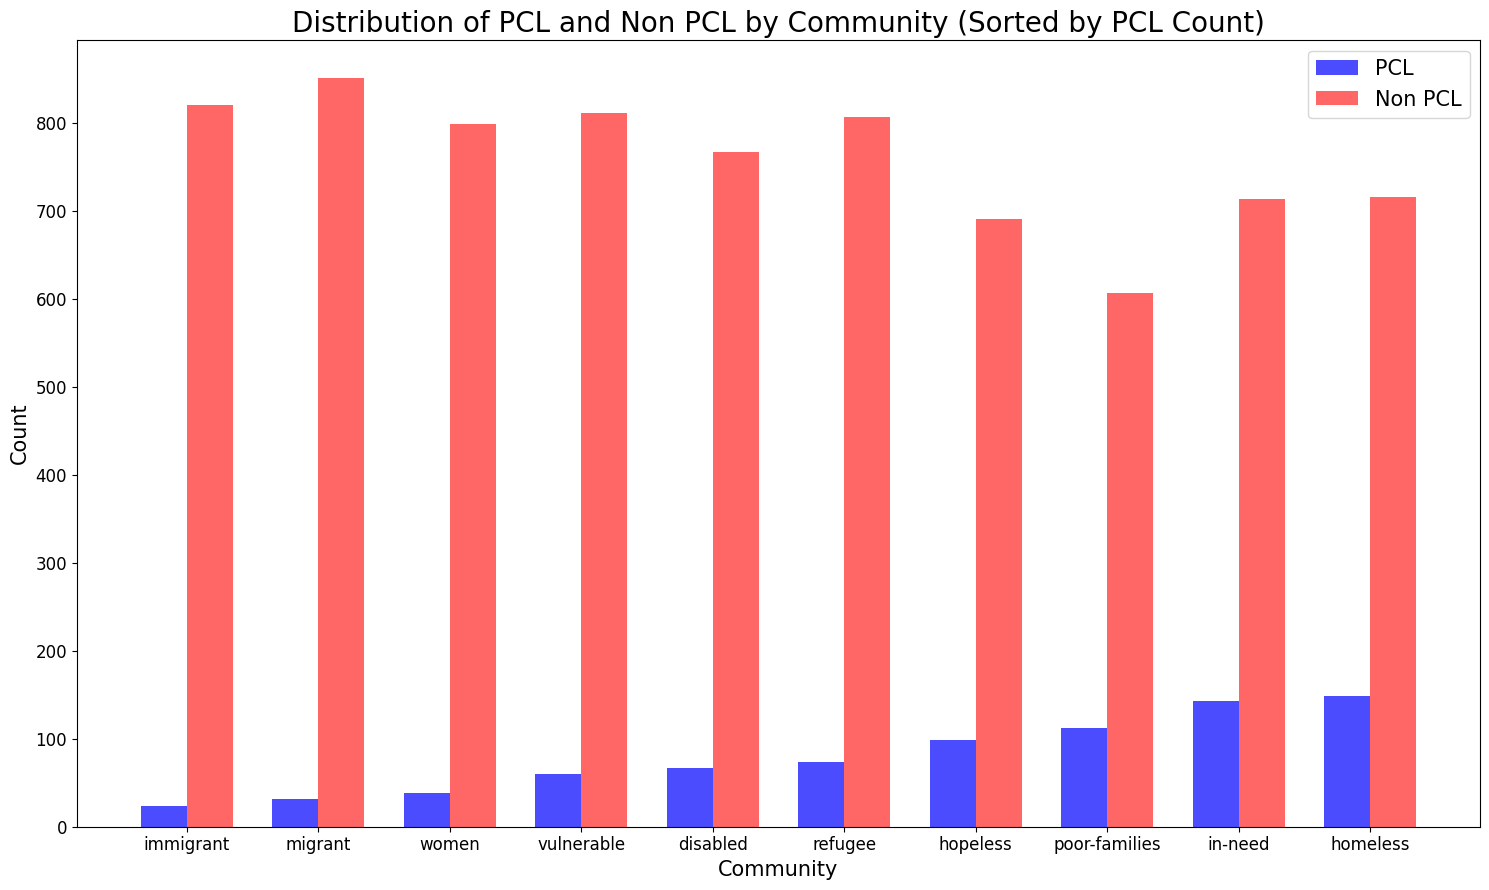

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Plot distribution of PCL and non PCL by community
pcls = train_set[train_set['label'] == 1]
non_pcls = train_set[train_set['label'] == 0]

pcls_by_community = pcls.groupby('community').size()
non_pcls_by_community = non_pcls.groupby('community').size()

# Combine and sort by PCL count
combined = pd.DataFrame({'PCL': pcls_by_community, 'Non PCL': non_pcls_by_community}).fillna(0)
combined['Total PCL'] = combined['PCL'] + combined['Non PCL']
combined_sorted = combined.sort_values(by='PCL', ascending=True)

fig, ax = plt.subplots(figsize=(15, 9))
bar_width = 0.35
index = np.arange(len(combined_sorted))

pcls_bar = plt.bar(index, combined_sorted['PCL'], bar_width, color='b', label='PCL', alpha=0.7)
non_pcls_bar = plt.bar(index + bar_width, combined_sorted['Non PCL'], bar_width, color='r', label='Non PCL', alpha=0.6)

plt.xlabel('Community', fontsize=15, rotation='horizontal')
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of PCL and Non PCL by Community (Sorted by PCL Count)', fontsize=20)
plt.xticks(index + bar_width / 2, combined_sorted.index, fontsize=12, rotation='horizontal')
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.tight_layout() 
plt.savefig('analysis3c_distribution_sorted.png')
plt.show()
